In [1]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import math
import scipy.stats as stats


import import_ipynb
from CustomDataset import ControlsDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
torch.cuda.empty_cache()
print('using device', device)

importing Jupyter notebook from CustomDataset.ipynb
using device cuda


In [2]:
dataset = ControlsDataset()
dataset.labels.num_categories = 21
dataset.labels.transform.categorize(1.05, -1.05, 21)
dataset.labels.infotype = "Category"
dataset.make_dataloaders()

Total training stacks 441
Total validation stacks 111


In [3]:
len(dataset)

11018

In [4]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [5]:
resnet50 = models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False

# resnet50.fc = nn.Sequential(nn.Linear(2048, 21))
resnet50.fc = nn.Sequential(nn.Linear(2048, 1))

resnet50 = resnet50.to(device)

In [6]:
# dont need
counts = dataset.labels.dataframe.groupby('Category')['ID'].count()
counts = np.array(counts)
ratio = max(counts)/counts

In [7]:
# dont need
A = np.ones((4,3))
B = np.arange(3)
print(B.shape)
print(A.shape)

R = np.multiply(B,A).T
print(R)

(3,)
(4, 3)
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]]


(20, 21)
(20, 1)


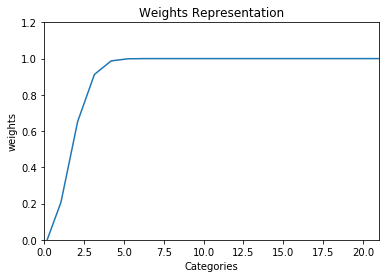

tensor([8.3188e+01, 1.3310e+02, 8.7566e+01, 7.7384e+01, 4.5582e+01, 3.0388e+01,
        1.5921e+01, 1.7606e+01, 7.6144e+00, 5.8275e+00, 1.0000e+00, 2.8199e+01,
        4.3214e+01, 1.0734e+02, 7.0053e+01, 6.7908e+01, 9.1164e+01, 2.4648e+02,
        1.4160e+02, 1.6638e+03, 6.7222e+01], device='cuda:0')


In [8]:
# dont need
batch_size = 20
index = 10
controls = np.arange(batch_size).reshape((batch_size,1))
mu = controls
variance = 2
sigma = np.sqrt(variance)
x = np.zeros((batch_size,21))
x[:] = np.linspace(0, 21, 21)
print(x.shape)
print(mu.shape)
pdf = stats.norm.pdf(x, mu, sigma)
maximum = 0.27
pdf = (maximum-pdf)/maximum

plt.xlim([0,21])
plt.ylim([0,1.2])
plt.plot(x[0], pdf[0])
plt.title("Weights Representation")
plt.xlabel("Categories")
plt.ylabel("weights")
plt.show()

weights = ratio
weights = torch.Tensor(weights).to(device)
print(weights)

In [9]:
epochs = 30
optimizer = optim.Adam(resnet50.parameters())
#criterion = nn.CrossEntropyLoss(weight=weights,reduction='none') # Changed from Mean-Squared to Cross-Entro

In [10]:
# score for classification
def score(model,device,dataset,single_batch = False):
    model.eval()
    total = 0
    correct = 0
    for i_batch, sampled_batch in enumerate(dataset.validloader):
        images = sampled_batch['image'].to(device).float()
        controls = sampled_batch['control'].to(device).long()
        controls = torch.flatten(controls)
        prediction = model(images)

        maximum = torch.argmax(prediction,dim = 1)
        shared = maximum == controls
        shared = 1 * shared
        correct += int(torch.sum(shared))
        total += len(controls)
        if single_batch:
            return (total,correct)
    return (total,correct)

In [13]:
from tqdm.notebook import tqdm_notebook
resnet50.train()
iter_no = 0
report_period = 20
percent = 0
for epoch in range(epochs):
    for i_batch, sampled_batch in tqdm_notebook(enumerate(dataset.dataloader),
                                                total=len(dataset.dataloader),
                                                desc= str(percent)):
        #inputs and forward pass
        images = sampled_batch['image'].to(device).float()
        controls = sampled_batch['control'].to(device).long()
        controls = torch.flatten(controls)

        #backwards pass
        optimizer.zero_grad()
        prediction = resnet50(images)
        #print(torch.argmax(prediction,dim=1))
        #print
        #print(controls)
        
        batch_size = 20
        index = 10
        mu = controls.reshape((batch_size,1))
        variance = 2
        sigma = np.sqrt(variance)
        x = np.zeros((batch_size,21))
        x[:] = np.linspace(0, 21, 21)
        #print(x.shape)
        #print(mu.shape)
        pdf = stats.norm.pdf(x, mu.cpu(), sigma)
        maximum = 0.27
        inv = (maximum-pdf)/maximum
        inv = torch.Tensor(inv).to(device)
        
        prediction = torch.abs(prediction)
        
        #loss = criterion(prediction, controls)
        loss = torch.mean(prediction*inv)
        loss.backward()
        optimizer.step()

        iter_no += 1
        if iter_no % report_period == 0:
            #self.writer.add_scalar("Loss", loss.item(), iter_no)
            print("saved to tensorboard")
            #self.save(epoch,"snapshots/{:.3f}_model.pt".format(loss.item()))

    out = "{0},{1}\tLoss:{2}\tAllocated:{3}GB\tCached:{4}GB\n"
    print(out.format(str(epoch),
                    str(iter_no),
                    round(loss.item(),5),
                     'na', 'na'
                     #round(torch.cuda.memory_allocated(0)/1024**3,3),
                     #round(torch.cuda.memory_allocated(0)/1024**3,3)
                    ))
    epoch_score = score(resnet50,device,dataset,True)
    total,correct = epoch_score
    percent = round(epoch_score[1]/epoch_score[0],3)*100
    #print(correct)
    #print(prediction)
    print("Accuracy: {}%".format(correct/total*100))

saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard
saved to tensorboard


RuntimeError: shape '[20, 1]' is invalid for input of size 15

In [ ]:
def save(epoch,model,path):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict()},
            path)

In [ ]:
save(100,resnet50,"resnet.pt")